In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.gaussian_process.kernels import RBF
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared,ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/My Drive/AML_exam.txt',sep='\t',header=(0))

In [4]:
df.head()

,Unnamed: 0,datetime,speed
0,0,201501010000,NaN
1,1,201501010100,NaN
2,2,201501010200,NaN
3,3,201501010300,NaN
4,4,201501010400,NaN


In [5]:
df.columns

Index(['Unnamed: 0', 'datetime', 'speed'], dtype='object')

In [6]:
df.drop('Unnamed: 0',inplace=True,axis=1)

In [7]:
df.head()

,datetime,speed
0,201501010000,NaN
1,201501010100,NaN
2,201501010200,NaN
3,201501010300,NaN
4,201501010400,NaN


In [8]:
df.dtypes

datetime      int64
speed       float64
dtype: object

In [9]:
df['datetime'] = pd.to_datetime(df['datetime'],format='%Y%m%d%H%M%S')

In [10]:
df

,datetime,speed
0,2015-01-01 00:00:00,NaN
1,2015-01-01 01:00:00,NaN
2,2015-01-01 02:00:00,NaN
3,2015-01-01 03:00:00,NaN
4,2015-01-01 04:00:00,NaN
...,...,...
35059,2018-12-31 19:00:00,2.148734
35060,2018-12-31 20:00:00,1.608662
35061,2018-12-31 21:00:00,0.647012
35062,2018-12-31 22:00:00,1.206987


In [11]:
df.isnull().sum()

datetime        0
speed       16515
dtype: int64

In [12]:

#Percentage of null values
df.isnull().sum().sum()* 100 / len(df)

47.09958932238193

In [13]:
df.shape

(35064, 2)

In [14]:
#So we gonna drop the null values since they do not offer us any insights
df.dropna(inplace=True)

In [15]:
#new shape
df.shape

(18549, 2)

In [16]:
df.head()

,datetime,speed
16500,2016-11-18 12:00:00,2.098724
16501,2016-11-18 13:00:00,1.570473
16502,2016-11-18 14:00:00,2.194121
16503,2016-11-18 15:00:00,1.308761
16504,2016-11-18 16:00:00,0.522000


<Figure size 216x216 with 0 Axes>

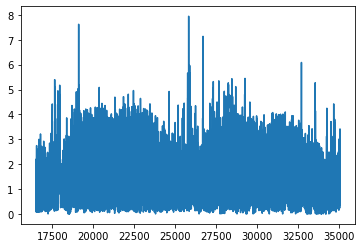

<Figure size 216x216 with 0 Axes>

In [17]:
plt.plot(df['speed'])
plt.figure(figsize=(3, 3))

In [18]:
#Converting the problem into a time series problem./ Using shift to create X and Y values
#df['speed-1'] = df['speed'].shift(24) # s
#df.head()

In [19]:
#df['speed-2']= df['speed'].shift(-24)

In [20]:
df.head()

,datetime,speed
16500,2016-11-18 12:00:00,2.098724
16501,2016-11-18 13:00:00,1.570473
16502,2016-11-18 14:00:00,2.194121
16503,2016-11-18 15:00:00,1.308761
16504,2016-11-18 16:00:00,0.522000


In [21]:
#df['speed-3']= df['speed'].shift(-3)

In [22]:
#Drop the null values
#df.dropna(inplace=True)

In [23]:
#Verify that there are no null values
#df.isnull().sum().sum()

In [24]:
import numpy as np

In [26]:
data = df['speed'].values

In [27]:
data.shape

(18549,)

In [28]:
# Percentage of data used. ( It takes so long to train a model i have iterated over and over again. On average it takes say 2.5 hours to work with 
# 50% of the data)
data = data[:int(data.shape[0]*0.50)]
data.shape

(9274,)

In [29]:
data = data.reshape(-1,1)

In [30]:
data.shape

(9274, 1)

In [31]:
#Time series feature extraction 

train_size = int(len(data)*0.7)
test_size = int(len(data)*0.3)

X_train = data[0:train_size,:]
X_test = data[train_size:len(data),:]

def sequences(data, combination=1):
    x = []
    y = []

    for i in range(len(data)-combination-1):
        window = data[i:(i+combination), 0]
        x.append(window)
        y.append(data[i+combination, 0])
        
    return np.array(x),np.array(y)

combination= 4  # Number of time steps to look back 

X_train, Y_train = sequences(X_train, combination)
X_test, Y_test = sequences(X_test, combination)

In [32]:

X_train.shape

(6486, 4)

## Kernel ridge regression (KRR)

In [33]:
# Parameters for grid search cv
param_grid = {"alpha": [100, 10,1e0, 1e-1, 1e-2, 1e-3,1e-4,1e-5],
              "kernel":['linear','rbf','polynomial','laplacian','chi'],
              "gamma":[10,1e0, 1e-1, 1e-2, 1e-3,1e-4],
              "degree":[3,4,5],
              "coef0":[2,3,4] 
              }

tscv = TimeSeriesSplit(n_splits=3)
kr = GridSearchCV(KernelRidge(), param_grid=param_grid, cv=tscv,return_train_score=True)
#[ExpSineSquared(l, p)for l in np.logspace(-2, 2, 10) for p in np.logspace(0, 2, 10)]

In [34]:
import warnings
warnings.simplefilter('ignore')

kr.fit(X_train,Y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score=nan,
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='linear', kernel_params=None),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [100, 10, 1.0, 0.1, 0.01, 0.001, 0.0001,
                                   1e-05],
                         'coef0': [2, 3, 4], 'degree': [3, 4, 5],
                         'gamma': [10, 1.0, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf', 'polynomial', 'laplacian',
                                    'chi']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [35]:
kr.best_estimator_

KernelRidge(alpha=0.01, coef0=2, degree=3, gamma=0.01, kernel='rbf',
            kernel_params=None)

In [36]:
kr.best_params_

{'alpha': 0.01, 'coef0': 2, 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf'}

In [37]:
kr.best_score_

0.6257712196969676

In [53]:
#Train performance predict
Y_predKR = kr.predict(X_train)
Y_predKR

array([1.18419742, 0.89659486, 0.85145227, ..., 0.82226086, 0.99735944,
       0.81393821])

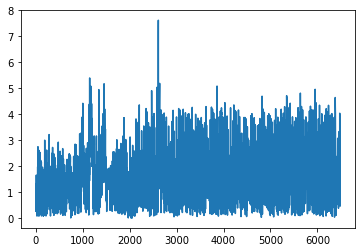

In [39]:
plt.plot(Y_train)

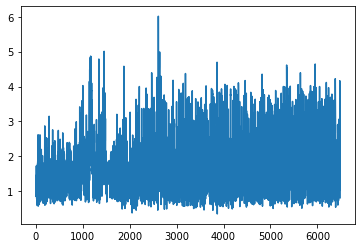

In [40]:
plt.plot(Y_predKR)

In [54]:
#Train score
uu= ((Y_train -Y_predKR) ** 2).sum()
v= ((Y_train - Y_train.mean()) ** 2).sum()
scorek = 1-(uu/v)
scorek

0.6571975243401016

In [55]:
#Train score
kr.score(X_train,Y_train)

0.6571975243401017

In [43]:
#Test score 
Y_predKR_test = kr.predict(X_test)

In [56]:
#Test score
uu= ((Y_test -Y_predKR_test) ** 2).sum()
v= ((Y_test - Y_test.mean()) ** 2).sum()
scorek = 1-(uu/v)
scorek

0.6168684351603742

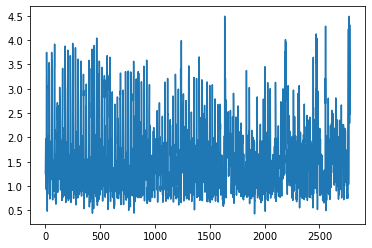

In [45]:
plt.plot(Y_predKR_test)

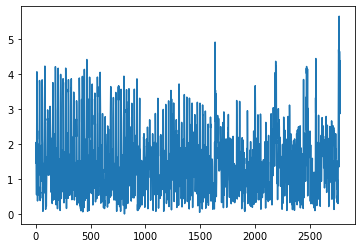

In [46]:
plt.plot(Y_test)

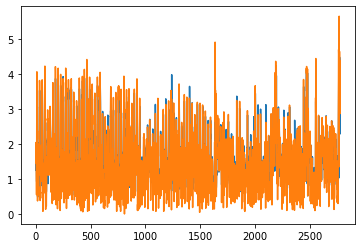

In [47]:
plt.plot(Y_predKR_test)
plt.plot(Y_test)

In [57]:
#Test score
kr.score(X_test,Y_test)


0.6168684351603742

# The performance tends to improve the more data i give the model. But due to the long time it takes to train i have not been giving it the full range. In comparison to the lstm which took 100% of the data without any problem and performance and time were undetered. 




## Root mean square evaluation for the best model both for training and testing set. 

In [60]:
#Root mean square error train
trainScore = math.sqrt(mean_squared_error(Y_train,Y_predKR ))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.57 RMSE


In [59]:
#Root mean square error test
testScore = math.sqrt(mean_squared_error(Y_test, Y_predKR_test))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.54 RMSE


# Gaussian Processes. (They they take long to train. The data used in this example is 15% of the whole data, and it took over 3hrs) So i dropped them due to that fact.Maybe i could reduce the number of kernels and parameters to train on.

In [37]:
tscv = TimeSeriesSplit(n_splits=3)

k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=12) * \
  ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

k2 = ConstantKernel(constant_value=10, constant_value_bounds=(1e-2, 1e3)) * \
  RBF(length_scale=1e2, length_scale_bounds=(1, 1e3)) 

kernel_2  = k0 + k1 + k2

kernel_1  = kernel_2 #1.0 * RBF(1.0) #k

kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
           kernel_1
           
           ]


param_grid = {"alpha": [10,1e0, 0.9,0.8,0.5],
              "kernel":kernels,
              "normalize_y":[True],
              "n_restarts_optimizer":[8,10]
              }           

gpr = GridSearchCV(GaussianProcessRegressor(), param_grid=param_grid, cv=tscv,return_train_score=True)

In [38]:

gpr.fit(X_train, Y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score=nan,
             estimator=GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                                kernel=None,
                                                n_restarts_optimizer=0,
                                                normalize_y=False,
                                                optimizer='fmin_l_bfgs_b',
                                                random_state=None),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [10, 1.0, 0.9, 0.8, 0.5],
                         'kernel': [1**2 * RBF(length_scale=1),
                                    1*..., length_scale=1),
                                    1**2 * ExpSineSquared(length_scale=1, periodicity=3),
                                    0.316**2 * DotProduct(sigma_0=1) ** 2,
                                    WhiteKernel(noise_level=0.09) + 3.46**2 * ExpSineSqu

In [39]:
y_pred = gpr.predict(X_test)

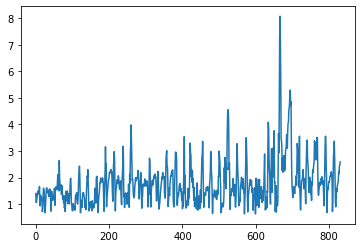

In [40]:
plt.plot(y_pred)

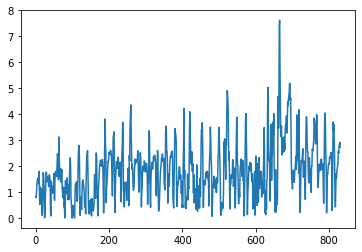

In [41]:
plt.plot(Y_test)

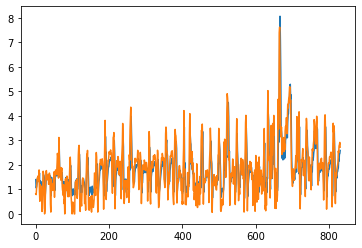

In [42]:
plt.plot(y_pred)
plt.plot(Y_test)

In [43]:
gpr.best_estimator_

GaussianProcessRegressor(alpha=10, copy_X_train=True,
                         kernel=0.316**2 * DotProduct(sigma_0=1) ** 2,
                         n_restarts_optimizer=10, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [44]:
gpr.best_score_

0.40487514388827356

In [45]:
gpr.best_params_

{'alpha': 10,
 'kernel': 0.316**2 * DotProduct(sigma_0=1) ** 2,
 'n_restarts_optimizer': 10,
 'normalize_y': True}

In [46]:
gpr.score(X_train,Y_train)

0.5726952139365772

In [47]:
gpr.score(X_test,Y_test)

0.5817347174180031

In [48]:
#Score 
#score = 1-(u/v)
u= ((Y_test - y_pred) ** 2).sum()
v= ((Y_test - Y_test.mean()) ** 2).sum()
score = 1-(u/v)
score

0.5817347174180031

In [50]:
y_pred_train = gpr.predict(X_train)

In [51]:
import math
trainScore = math.sqrt(mean_squared_error(Y_train,y_pred_train ))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.54 RMSE


In [52]:
testScore = math.sqrt(mean_squared_error(Y_test, y_pred))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.68 RMSE
